# Exercise 2
### Group "21CenturyBoys": Mattia Ceravolo, Lorenzo Borella, Samuele Lipani, Marco Giunta.

### Final test accuracy: 0.960


# Part 1: check if the NN converges for a smaller set of training data

### Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adamax
from keras.layers import Conv1D,Conv2D, MaxPooling1D, AveragePooling1D, AveragePooling2D

import time
import math

### Data (strings) and splitting

In [2]:
fname="sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter = ",",
                    usecols=(0,1), unpack=True, dtype=str)

N=len(sy) #number of samples
Ls=len(sx[0]) #length of each string

perc_train=0.8
N_train=int(N*perc_train)
N_test=N-N_train

#one-hot encoding to associate each character to a sequence of 0 and 1
Q = ["A","C","G","T"]
Nc=4
onehc={Q[i]:i for i in range(Nc)} #one-hot encoding
print(onehc)

y = sy.astype(int) #data conversion 
L = Ls*Nc #length of input layer
x = np.zeros((N,L)) #every row is an input

for n in range(N): #for each sample
    for i in range(Ls): #for each character
        x[n][i*4 + onehc[sx[n][i]]] = 1
        
x = x.reshape((x.shape[0],int(x.shape[1]/4),4,1))

#split tain/test-validation
(x_train,y_train) = (x[:N_train],y[:N_train]) #TRAINING SET
(x_test,y_test)  = (x[N_train:],y[N_train:]) #TEST SET

print("Fraction of data=1 in the training:",y_train.sum()/N_train)
print("Fraction of data=1 in the test:",y_test.sum()/N_test)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}
Fraction of data=1 in the training: 0.24333333333333335
Fraction of data=1 in the test: 0.25833333333333336


In [3]:
x_train.shape

(2400, 16, 4, 1)

### Definition the optimizers

Differents learning rates for the SGD were used during grid search in Part 3 and we found that the best one was 0.1. Therefore we are assuming here the same learning rate holds for other optimizers. We omitted the code where we do this for brevity. 

In [4]:
opt1 = SGD(learning_rate=0.1,
           momentum=0.9,
           nesterov=True) 

opt2 = RMSprop(learning_rate=0.1)

opt3 = Adam(learning_rate=0.1)

## Definition of model in keras

### Optimization

We defined the DNN model inside a function. This is useful to execute the grid search later. We added the parameter x_f that changes (if different from 1) the numbers of neurons in the first hidden layer.

In [14]:
from keras import regularizers, initializers
reg = regularizers.l1(0.0001) #lasso, with 0.1 doesn't converge
#ini = initializers.RandomNormal(mean=0,stddev=0.5) #initialization of the weigths



def compile_model(optimizer=opt1,activation="relu",dropout_rate=0, x_f = 4,n_f = 5):
    
    # create the mode
    model = Sequential()
    
    model.add(Conv2D(filters=n_f,kernel_size=(6,4), 
                 activation="relu",
                 input_shape=(16,4,1),
                 kernel_regularizer=reg
                 #kernel_initializer=ini
                 ))
    #model.add(AveragePooling2D((2,1))) #first and only pooling; from 5 numbers to 1

    #model.add(Conv2D(filters=25, kernel_size=(4,1), activation="relu"))
    model.add(Flatten())
    model.add(Dense(x_f*L,activation=activation)) 
    model.add(Dense(L/2,activation=activation))
    model.add(Dense(L/4,activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    
    # compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

### Function to fit and plot

In [9]:
#Compact function to train the model and fit it
def fit_and_plot(model = compile_model(), x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test, epochs = 50, batch_size =20):
    
    fit = model.fit(x_train, y_train, 
               epochs=epochs, batch_size=batch_size,
               validation_data=(x_test,y_test),
                shuffle=True)
    #Plot the results

    score = model.evaluate(x_test, y_test, verbose=1)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    # look into training history

    # summarize history for accuracy
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                                   epochs=3,  
                                   verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = [opt1]
activation = ["relu"]
dropout_rate = [0,0.2,0.4]
batch_size= [10, 20,50]
x_f = [8, 12,16]
n_f = [50, 75, 100]
# define parameter dictionary
param_grid = dict(x_f = x_f, n_f = n_f, batch_size= batch_size, dropout_rate=dropout_rate )
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/3
180/180 [==============================] - 2s 8ms/step - loss: 0.5890 - accuracy: 0.7351
Epoch 2/3
180/180 [==============================] - 1s 7ms/step - loss: 0.5394 - accuracy: 0.7648
Epoch 3/3
60/60 [==============================] - 1s 4ms/step - loss: 0.2187 - accuracy: 0.9200
Epoch 1/3
180/180 [==============================] - 2s 6ms/step - loss: 0.5677 - accuracy: 0.7134
Epoch 2/3
180/180 [==============================] - 1s 6ms/step - loss: 0.4233 - accuracy: 0.8080
Epoch 3/3
60/60 [==============================] - 1s 4ms/step - loss: 0.2159 - accuracy: 0.9233
Epoch 1/3
180/180 [==============================] - 2s 6ms/step - loss: 0.5756 - accuracy: 0.7323
Epoch 2/3
180/180 [==============================] - 1s 6ms/step - loss: 0.3776 - accuracy: 0.8168
Epoch 3/3
60/60 [==============================] - 1s 9ms/step - loss: 0.2339 - accuracy: 0.8867
Epoch 1/3
180/180 [==============================] - 3s 10ms/step - loss: 0.5709 - accuracy: 0.7485
Epoch 2/3
180/1

180/180 [==============================] - 3s 13ms/step - loss: 0.5513 - accuracy: 0.7517 0s
Epoch 2/3
180/180 [==============================] - 3s 19ms/step - loss: 0.3214 - accuracy: 0.8605
Epoch 3/3
60/60 [==============================] - 1s 8ms/step - loss: 0.1034 - accuracy: 0.9850
Epoch 1/3
180/180 [==============================] - 5s 20ms/step - loss: 0.5963 - accuracy: 0.7298
Epoch 2/3
180/180 [==============================] - 3s 16ms/step - loss: 0.5452 - accuracy: 0.7733
Epoch 3/3
60/60 [==============================] - 1s 4ms/step - loss: 0.5258 - accuracy: 0.7667
Epoch 1/3
180/180 [==============================] - 4s 15ms/step - loss: 0.5761 - accuracy: 0.7468
Epoch 2/3
180/180 [==============================] - 3s 18ms/step - loss: 0.4615 - accuracy: 0.7584
Epoch 3/3
60/60 [==============================] - 1s 10ms/step - loss: 0.2423 - accuracy: 0.8517
Epoch 1/3
180/180 [==============================] - 6s 21ms/step - loss: 0.5566 - accuracy: 0.7618
Epoch 2/3
180/1

180/180 [==============================] - 3s 11ms/step - loss: 0.5870 - accuracy: 0.7373
Epoch 2/3
180/180 [==============================] - 2s 12ms/step - loss: 0.5538 - accuracy: 0.7556
Epoch 3/3
60/60 [==============================] - 1s 7ms/step - loss: 0.2798 - accuracy: 0.8650
Epoch 1/3
180/180 [==============================] - 2s 7ms/step - loss: 0.5671 - accuracy: 0.7450
Epoch 2/3
180/180 [==============================] - 1s 7ms/step - loss: 0.5985 - accuracy: 0.7550
Epoch 3/3
60/60 [==============================] - 0s 3ms/step - loss: 0.5975 - accuracy: 0.7483
Epoch 1/3
180/180 [==============================] - 2s 10ms/step - loss: 0.5854 - accuracy: 0.7279
Epoch 2/3
180/180 [==============================] - 2s 11ms/step - loss: 0.4562 - accuracy: 0.7818
Epoch 3/3
60/60 [==============================] - 1s 3ms/step - loss: 0.2740 - accuracy: 0.8600
Epoch 1/3
180/180 [==============================] - 2s 10ms/step - loss: 0.5734 - accuracy: 0.7604
Epoch 2/3
180/180 [==

180/180 [==============================] - 2s 9ms/step - loss: 0.5807 - accuracy: 0.7401
Epoch 2/3
180/180 [==============================] - 1s 8ms/step - loss: 0.5660 - accuracy: 0.7488
Epoch 3/3
60/60 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.8250
Epoch 1/3
180/180 [==============================] - 2s 10ms/step - loss: 0.5816 - accuracy: 0.7442
Epoch 2/3
180/180 [==============================] - 2s 10ms/step - loss: 0.5519 - accuracy: 0.7564
Epoch 3/3
60/60 [==============================] - 0s 3ms/step - loss: 0.5258 - accuracy: 0.7683
Epoch 1/3
180/180 [==============================] - 3s 11ms/step - loss: 0.5721 - accuracy: 0.7460
Epoch 2/3
180/180 [==============================] - 2s 10ms/step - loss: 0.5055 - accuracy: 0.7594
Epoch 3/3
60/60 [==============================] - 0s 3ms/step - loss: 0.2812 - accuracy: 0.8733
Epoch 1/3
180/180 [==============================] - 3s 11ms/step - loss: 0.5714 - accuracy: 0.7484
Epoch 2/3
180/180 [==

180/180 [==============================] - 1s 6ms/step - loss: 0.5361 - accuracy: 0.7576
Epoch 3/3
60/60 [==============================] - 0s 3ms/step - loss: 0.2556 - accuracy: 0.9017
Epoch 1/3
180/180 [==============================] - 2s 7ms/step - loss: 0.5538 - accuracy: 0.7510
Epoch 2/3
180/180 [==============================] - 1s 7ms/step - loss: 0.5187 - accuracy: 0.7698
Epoch 3/3
60/60 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.8300
Epoch 1/3
180/180 [==============================] - 2s 7ms/step - loss: 0.5749 - accuracy: 0.7521
Epoch 2/3
180/180 [==============================] - 1s 7ms/step - loss: 0.5389 - accuracy: 0.7476
Epoch 3/3
60/60 [==============================] - 0s 3ms/step - loss: 0.2993 - accuracy: 0.8567
Epoch 1/3
180/180 [==============================] - 2s 7ms/step - loss: 0.5554 - accuracy: 0.7667
Epoch 2/3
180/180 [==============================] - 1s 6ms/step - loss: 0.5740 - accuracy: 0.7472
Epoch 3/3
60/60 [=========

60/60 [==============================] - 0s 3ms/step - loss: 0.2785 - accuracy: 0.8767
Epoch 1/3
180/180 [==============================] - 3s 13ms/step - loss: 0.5860 - accuracy: 0.7542
Epoch 2/3
180/180 [==============================] - 3s 15ms/step - loss: 0.5266 - accuracy: 0.7599
Epoch 3/3
60/60 [==============================] - 0s 4ms/step - loss: 0.3049 - accuracy: 0.8633
Epoch 1/3
180/180 [==============================] - 3s 14ms/step - loss: 0.5798 - accuracy: 0.7329
Epoch 2/3
180/180 [==============================] - 2s 13ms/step - loss: 0.5702 - accuracy: 0.7507
Epoch 3/3
60/60 [==============================] - 0s 4ms/step - loss: 0.5828 - accuracy: 0.7483
Epoch 1/3
90/90 [==============================] - 1s 6ms/step - loss: 0.5748 - accuracy: 0.7459
Epoch 2/3
90/90 [==============================] - 1s 6ms/step - loss: 0.4621 - accuracy: 0.7553: 0s - loss: 0.5224 
Epoch 3/3
30/30 [==============================] - 0s 3ms/step - loss: 0.2508 - accuracy: 0.8633
Epoch 1/

90/90 [==============================] - 2s 11ms/step - loss: 0.5706 - accuracy: 0.7296
Epoch 2/3
90/90 [==============================] - 1s 12ms/step - loss: 0.4335 - accuracy: 0.7738
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.1428 - accuracy: 0.9550
Epoch 1/3
90/90 [==============================] - 2s 15ms/step - loss: 0.5754 - accuracy: 0.7715
Epoch 2/3
90/90 [==============================] - 1s 14ms/step - loss: 0.4475 - accuracy: 0.7839
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9417
Epoch 1/3
90/90 [==============================] - 2s 13ms/step - loss: 0.5560 - accuracy: 0.7676
Epoch 2/3
90/90 [==============================] - 1s 13ms/step - loss: 0.3981 - accuracy: 0.8254
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9733
Epoch 1/3
90/90 [==============================] - 3s 13ms/step - loss: 0.5721 - accuracy: 0.7476
Epoch 2/3
90/90 [================

30/30 [==============================] - 0s 3ms/step - loss: 0.1326 - accuracy: 0.9683
Epoch 1/3
90/90 [==============================] - 1s 7ms/step - loss: 0.5796 - accuracy: 0.7202
Epoch 2/3
90/90 [==============================] - 1s 8ms/step - loss: 0.4992 - accuracy: 0.7595
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.2419 - accuracy: 0.9000
Epoch 1/3
90/90 [==============================] - 2s 16ms/step - loss: 0.5772 - accuracy: 0.7522
Epoch 2/3
90/90 [==============================] - 1s 9ms/step - loss: 0.4022 - accuracy: 0.7865
Epoch 3/3
30/30 [==============================] - 0s 5ms/step - loss: 0.2513 - accuracy: 0.8683
Epoch 1/3
90/90 [==============================] - 1s 8ms/step - loss: 0.5567 - accuracy: 0.7552
Epoch 2/3
90/90 [==============================] - 1s 8ms/step - loss: 0.4584 - accuracy: 0.7786
Epoch 3/3
30/30 [==============================] - 0s 8ms/step - loss: 0.2984 - accuracy: 0.8733
Epoch 1/3
90/90 [======================

90/90 [==============================] - 1s 9ms/step - loss: 0.5712 - accuracy: 0.7305
Epoch 2/3
90/90 [==============================] - 1s 8ms/step - loss: 0.3801 - accuracy: 0.8202
Epoch 3/3
30/30 [==============================] - 0s 3ms/step - loss: 0.1865 - accuracy: 0.9483
Epoch 1/3
90/90 [==============================] - 1s 9ms/step - loss: 0.5734 - accuracy: 0.7537
Epoch 2/3
90/90 [==============================] - 1s 8ms/step - loss: 0.4643 - accuracy: 0.7798
Epoch 3/3
30/30 [==============================] - 0s 3ms/step - loss: 0.0602 - accuracy: 0.9950
Epoch 1/3
90/90 [==============================] - 2s 11ms/step - loss: 0.5876 - accuracy: 0.7153
Epoch 2/3
90/90 [==============================] - 1s 11ms/step - loss: 0.4808 - accuracy: 0.7808
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.2339 - accuracy: 0.8983
Epoch 1/3
90/90 [==============================] - 2s 11ms/step - loss: 0.5648 - accuracy: 0.7557
Epoch 2/3
90/90 [====================

30/30 [==============================] - 0s 3ms/step - loss: 0.2597 - accuracy: 0.8683
Epoch 1/3
90/90 [==============================] - 1s 8ms/step - loss: 0.5839 - accuracy: 0.7451
Epoch 2/3
90/90 [==============================] - 1s 9ms/step - loss: 0.4994 - accuracy: 0.7686
Epoch 3/3
30/30 [==============================] - 0s 3ms/step - loss: 0.1231 - accuracy: 0.9667
Epoch 1/3
90/90 [==============================] - 1s 7ms/step - loss: 0.5663 - accuracy: 0.7568
Epoch 2/3
90/90 [==============================] - 1s 8ms/step - loss: 0.4888 - accuracy: 0.7690
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.2439 - accuracy: 0.8717
Epoch 1/3
90/90 [==============================] - 1s 9ms/step - loss: 0.5856 - accuracy: 0.7484
Epoch 2/3
90/90 [==============================] - 1s 8ms/step - loss: 0.5478 - accuracy: 0.7419
Epoch 3/3
30/30 [==============================] - 0s 3ms/step - loss: 0.2365 - accuracy: 0.9067
Epoch 1/3
90/90 [=======================

90/90 [==============================] - 2s 15ms/step - loss: 0.5840 - accuracy: 0.7474
Epoch 2/3
90/90 [==============================] - 1s 14ms/step - loss: 0.4680 - accuracy: 0.7818
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.2124 - accuracy: 0.9267
Epoch 1/3
90/90 [==============================] - 2s 16ms/step - loss: 0.5799 - accuracy: 0.7434
Epoch 2/3
90/90 [==============================] - 1s 16ms/step - loss: 0.4334 - accuracy: 0.7829
Epoch 3/3
30/30 [==============================] - 1s 7ms/step - loss: 0.1855 - accuracy: 0.9333
Epoch 1/3
90/90 [==============================] - 2s 15ms/step - loss: 0.5838 - accuracy: 0.7262
Epoch 2/3
90/90 [==============================] - 1s 15ms/step - loss: 0.5390 - accuracy: 0.7464
Epoch 3/3
30/30 [==============================] - 0s 4ms/step - loss: 0.2660 - accuracy: 0.8917
Epoch 1/3
36/36 [==============================] - 1s 7ms/step - loss: 0.5823 - accuracy: 0.7385
Epoch 2/3
36/36 [=================

Epoch 3/3
12/12 [==============================] - 1s 10ms/step - loss: 0.3560 - accuracy: 0.8200
Epoch 1/3
36/36 [==============================] - 1s 12ms/step - loss: 0.5828 - accuracy: 0.7522
Epoch 2/3
36/36 [==============================] - 0s 13ms/step - loss: 0.4808 - accuracy: 0.7753
Epoch 3/3
12/12 [==============================] - 0s 5ms/step - loss: 0.3340 - accuracy: 0.8450
Epoch 1/3
36/36 [==============================] - 1s 15ms/step - loss: 0.6092 - accuracy: 0.7208
Epoch 2/3
36/36 [==============================] - 1s 22ms/step - loss: 0.5271 - accuracy: 0.7579
Epoch 3/3
12/12 [==============================] - 0s 8ms/step - loss: 0.5114 - accuracy: 0.7367
Epoch 1/3
36/36 [==============================] - 1s 18ms/step - loss: 0.5573 - accuracy: 0.7685
Epoch 2/3
36/36 [==============================] - 1s 15ms/step - loss: 0.4613 - accuracy: 0.7899
Epoch 3/3
12/12 [==============================] - 0s 6ms/step - loss: 0.4787 - accuracy: 0.7550
Epoch 1/3
36/36 [======

12/12 [==============================] - 0s 4ms/step - loss: 0.7984 - accuracy: 0.4600
Epoch 1/3
36/36 [==============================] - 1s 9ms/step - loss: 0.5940 - accuracy: 0.7244
Epoch 2/3
36/36 [==============================] - 0s 10ms/step - loss: 0.5194 - accuracy: 0.7497
Epoch 3/3
12/12 [==============================] - 0s 6ms/step - loss: 0.2628 - accuracy: 0.9000
Epoch 1/3
36/36 [==============================] - 1s 9ms/step - loss: 0.5753 - accuracy: 0.7548
Epoch 2/3
36/36 [==============================] - 0s 11ms/step - loss: 0.4939 - accuracy: 0.7674
Epoch 3/3
12/12 [==============================] - 0s 8ms/step - loss: 0.3037 - accuracy: 0.8417
Epoch 1/3
36/36 [==============================] - 1s 13ms/step - loss: 0.6019 - accuracy: 0.7187
Epoch 2/3
36/36 [==============================] - 0s 12ms/step - loss: 0.5016 - accuracy: 0.7610
Epoch 3/3
12/12 [==============================] - 0s 4ms/step - loss: 0.2504 - accuracy: 0.8833
Epoch 1/3
36/36 [===================

Epoch 2/3
36/36 [==============================] - 0s 11ms/step - loss: 0.4829 - accuracy: 0.7806
Epoch 3/3
12/12 [==============================] - 0s 5ms/step - loss: 0.3007 - accuracy: 0.8700
Epoch 1/3
36/36 [==============================] - 1s 13ms/step - loss: 0.5938 - accuracy: 0.7277
Epoch 2/3
36/36 [==============================] - 0s 11ms/step - loss: 0.4850 - accuracy: 0.7590
Epoch 3/3
12/12 [==============================] - 0s 4ms/step - loss: 0.2884 - accuracy: 0.9067
Epoch 1/3
36/36 [==============================] - 1s 9ms/step - loss: 0.6086 - accuracy: 0.7091
Epoch 2/3
36/36 [==============================] - 0s 12ms/step - loss: 0.5525 - accuracy: 0.7531
Epoch 3/3
12/12 [==============================] - 0s 4ms/step - loss: 0.4451 - accuracy: 0.7483
Epoch 1/3
36/36 [==============================] - 1s 15ms/step - loss: 0.5864 - accuracy: 0.7251
Epoch 2/3
36/36 [==============================] - 0s 13ms/step - loss: 0.5245 - accuracy: 0.7373
Epoch 3/3
12/12 [=======

12/12 [==============================] - 0s 4ms/step - loss: 0.2502 - accuracy: 0.8983
Epoch 1/3
36/36 [==============================] - 1s 12ms/step - loss: 0.5877 - accuracy: 0.7443
Epoch 2/3
36/36 [==============================] - 1s 13ms/step - loss: 0.4990 - accuracy: 0.7581
Epoch 3/3
12/12 [==============================] - 0s 6ms/step - loss: 0.3739 - accuracy: 0.7600
Epoch 1/3
36/36 [==============================] - 1s 12ms/step - loss: 0.6082 - accuracy: 0.7117
Epoch 2/3
36/36 [==============================] - 0s 10ms/step - loss: 0.5595 - accuracy: 0.7503
Epoch 3/3
12/12 [==============================] - 1s 4ms/step - loss: 0.4065 - accuracy: 0.8033
Epoch 1/3
36/36 [==============================] - 1s 9ms/step - loss: 0.6047 - accuracy: 0.7235
Epoch 2/3
36/36 [==============================] - 0s 11ms/step - loss: 0.5367 - accuracy: 0.7563
Epoch 3/3
12/12 [==============================] - 0s 4ms/step - loss: 0.4856 - accuracy: 0.7517
Epoch 1/3
36/36 [==================

36/36 [==============================] - 1s 19ms/step - loss: 0.5942 - accuracy: 0.7125
Epoch 2/3
36/36 [==============================] - 1s 23ms/step - loss: 0.5205 - accuracy: 0.7595
Epoch 3/3
12/12 [==============================] - 0s 7ms/step - loss: 0.3409 - accuracy: 0.8233
Epoch 1/3
36/36 [==============================] - 1s 21ms/step - loss: 0.5953 - accuracy: 0.7226
Epoch 2/3
36/36 [==============================] - 1s 21ms/step - loss: 0.5261 - accuracy: 0.7590
Epoch 3/3
12/12 [==============================] - 0s 7ms/step - loss: 0.4550 - accuracy: 0.7433
Epoch 1/3
36/36 [==============================] - 2s 28ms/step - loss: 0.5984 - accuracy: 0.7492
Epoch 2/3
36/36 [==============================] - 1s 20ms/step - loss: 0.5245 - accuracy: 0.7471
Epoch 3/3
12/12 [==============================] - 0s 7ms/step - loss: 0.2734 - accuracy: 0.8733
Epoch 1/3
36/36 [==============================] - 2s 23ms/step - loss: 0.5921 - accuracy: 0.7516
Epoch 2/3
36/36 [================

Epoch 1/50
120/120 [==============================] - 4s 19ms/step - loss: 0.5481 - accuracy: 0.7565 - val_loss: 0.3992 - val_accuracy: 0.8100
Epoch 2/50
120/120 [==============================] - 2s 13ms/step - loss: 0.3038 - accuracy: 0.8568 - val_loss: 0.2679 - val_accuracy: 0.8533
Epoch 3/50
120/120 [==============================] - 2s 18ms/step - loss: 0.1426 - accuracy: 0.9521 - val_loss: 0.1007 - val_accuracy: 0.9767
Epoch 4/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0477 - accuracy: 0.9943 - val_loss: 0.0676 - val_accuracy: 0.9917
Epoch 5/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0365 - accuracy: 0.9985 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 6/50
120/120 [==============================] - 2s 15ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 7/50
120/120 [==============================] - 1s 12ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 1.0000

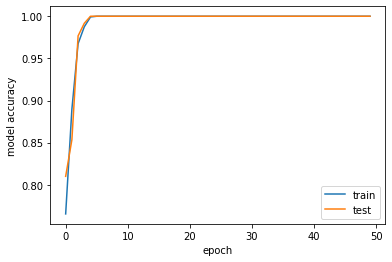

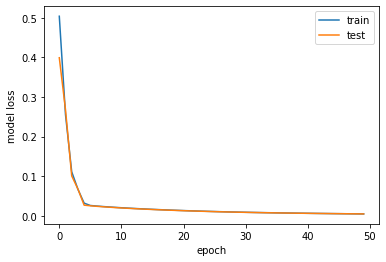

In [21]:
fit_and_plot(model = compile_model(dropout_rate=0, x_f = 12,n_f = 75), epochs = 50, batch_size =20)

Because of the decreased number of samples in the training set, the NN doesn't menage to converge. We see in fact that not only the test set increases during each iteration but also that the difference between the training test and the test one is large, meaning overfitting of the model. It's probably due to the small number of samples for training, leading the NN to adapt only on that non representative set and not being able to generalize for "real" samples.

# Part 2: data augmentation

To enlarge the training set, since we have sequences of nucleotides, we can shift one nucleotide to the left and all the others following. Therefore we keep the meaning of the sequence and we increment the number of training samples. What we want to discover is a particoular key giving the label 1 to certain sequences instead of others. We don't know the law that generated the data, so when shifting one character there will be one shift that will corrupt the underlying law assigning the labels, since it is based on the order of two or more near letters. One of the 16-1 possible shifts will certainly cause the above situation.

In [159]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], 4)

new_x_train=[]
new_y_train=[]

for j in range(x_train_reshape.shape[0]):
    for i in range(x_train_reshape[j].shape[0]):
        new_x_train.append(np.concatenate((x_train_reshape[j][i:],x_train_reshape[j][:i])))
        new_y_train.append(y_train[j])

new_y_train = np.array(new_y_train)
new_x_train = np.array(new_x_train).reshape(len(new_x_train), x_train.shape[1], x_train.shape[2], 1)

In [160]:
fit_and_plot(compile_model(), new_x_train, new_y_train)

Epoch 1/50
1920/1920 [==============================] - 6s 3ms/step - loss: 0.4611 - accuracy: 0.7989 - val_loss: 0.3345 - val_accuracy: 0.8650
Epoch 2/50
1920/1920 [==============================] - 5s 3ms/step - loss: 0.3883 - accuracy: 0.8476 - val_loss: 0.2942 - val_accuracy: 0.9183
Epoch 3/50
1920/1920 [==============================] - 7s 3ms/step - loss: 0.3930 - accuracy: 0.8476 - val_loss: 0.3231 - val_accuracy: 0.8967
Epoch 4/50
1920/1920 [==============================] - 5s 3ms/step - loss: 0.4607 - accuracy: 0.8090 - val_loss: 0.5713 - val_accuracy: 0.7417
Epoch 5/50
1920/1920 [==============================] - 7s 4ms/step - loss: 0.5584 - accuracy: 0.7559 - val_loss: 0.5730 - val_accuracy: 0.7417
Epoch 6/50
1920/1920 [==============================] - 6s 3ms/step - loss: 0.5584 - accuracy: 0.7550 - val_loss: 0.5731 - val_accuracy: 0.7417
Epoch 7/50
1920/1920 [==============================] - 4s 2ms/step - loss: 0.5555 - accuracy: 0.7582 - val_loss: 0.5728 - val_accuracy:

KeyboardInterrupt: 

We can see that despite the corruption of a certain amount of data loosing their correct label and key, data augmentation led the model to achieve a better test error and to avoid overfitting

# Part 3 : gridsearch in NN hyperaparameters

We decide now to gridsearch for the optimal set of hyperparameters of our NN including the architecture, dropout probability, activation functions and backpropagation optimizer algorithm. We create a validation set of which we will see later the purpose.

In [179]:
# create a real validation set and shuffle data

np.random.seed(1234)
mask = np.random.shuffle(np.arange(new_x_train.shape[0]))
mask

new_x_train = new_x_train[mask]
new_y_train = new_y_train[mask]

new_x_val = new_x_train[0, 30000:]
new_y_val = new_y_train[0, 30000:]
new_x_train = new_x_train[0, :30000]
new_y_train = new_y_train[0, :30000]

In [119]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                                   epochs=3,  
                                   verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = [opt1,opt2,opt3]
activation = ["relu","elu","tanh"]
dropout_rate = [0,0.2,0.4]
batch_size= [20,50,100]
x_f = [0.5,1,2]
# define parameter dictionary
param_grid = dict(optimizer=optimizer,activation=activation,dropout_rate=dropout_rate, batch_size = batch_size, x_f = x_f)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(new_x_train,new_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5293 - accuracy: 0.7505
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4444 - accuracy: 0.7893
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3279 - accuracy: 0.8623
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5066 - accuracy: 0.7685
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4369 - accuracy: 0.7968
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.4230 - accuracy: 0.8143
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5147 - accuracy: 0.7636
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4419 - accuracy: 0.7955
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.4023 - accuracy: 0.8172
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5222 - accuracy: 0.7

375/375 [==============================] - 1s 1ms/step - loss: 0.3773 - accuracy: 0.8360
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5132 - accuracy: 0.7621
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4302 - accuracy: 0.8060
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3835 - accuracy: 0.8293
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5196 - accuracy: 0.7587
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4425 - accuracy: 0.7990
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3004 - accuracy: 0.8768
Epoch 1/3
1125/1125 [==============================] - 3s 1ms/step - loss: 0.5319 - accuracy: 0.7505
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.4266 - accuracy: 0.8071
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3125 - accuracy: 0.8797
Epoch 1/

1125/1125 [==============================] - 2s 1ms/step - loss: 0.5342 - accuracy: 0.7553
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4621 - accuracy: 0.7778
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3323 - accuracy: 0.8561
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5823 - accuracy: 0.7456
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.5650 - accuracy: 0.7498
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5295 - accuracy: 0.7787
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.7463 - accuracy: 0.7644
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.5497 - accuracy: 0.7632
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5774 - accuracy: 0.7381
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.7321 - accuracy: 0.7598
Epoch 

150/150 [==============================] - 0s 1ms/step - loss: 0.5286 - accuracy: 0.7787
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 2.3835 - accuracy: 0.7506
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5499 - accuracy: 0.7621
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5772 - accuracy: 0.7381
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 2.1658 - accuracy: 0.7476
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5440 - accuracy: 0.7677
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5708 - accuracy: 0.7424
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 1.4872 - accuracy: 0.7366
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5603 - accuracy: 0.7531
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5366 - accuracy: 0.7723
Epoch 1/3
450/450 [=

150/150 [==============================] - 0s 1ms/step - loss: 0.4306 - accuracy: 0.8113
Epoch 1/3
450/450 [==============================] - 2s 1ms/step - loss: 0.5344 - accuracy: 0.7552
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.4676 - accuracy: 0.7798
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.4218 - accuracy: 0.7975
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5351 - accuracy: 0.7455
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.4717 - accuracy: 0.7779
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.3740 - accuracy: 0.8356
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5299 - accuracy: 0.7516
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.4289 - accuracy: 0.8029
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.3292 - accuracy: 0.8607
Epoch 1/3
450/450 [=

Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 5.7131 - accuracy: 0.7379
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5591 - accuracy: 0.7555
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5365 - accuracy: 0.7723
Epoch 1/3
450/450 [==============================] - 2s 2ms/step - loss: 1.0116 - accuracy: 0.7412
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5728 - accuracy: 0.7507
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5334 - accuracy: 0.7787
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 1.7995 - accuracy: 0.7503
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7653
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5778 - accuracy: 0.7381
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.7294 - accuracy: 0.7556
Epoch 2/3


450/450 [==============================] - 1s 1ms/step - loss: 0.5403 - accuracy: 0.7427
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.4286 - accuracy: 0.7986
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.8740
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5252 - accuracy: 0.7575
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.4098 - accuracy: 0.8085
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.4018 - accuracy: 0.8392
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5163 - accuracy: 0.7604
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.4405 - accuracy: 0.7946
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.3425 - accuracy: 0.8391
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5283 - accuracy: 0.7556
Epoch 2/3
450/450 [=

225/225 [==============================] - 0s 2ms/step - loss: 0.5439 - accuracy: 0.7677
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5273 - accuracy: 0.7424
Epoch 1/3
225/225 [==============================] - 1s 1ms/step - loss: 1.9097 - accuracy: 0.7351
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5315 - accuracy: 0.7522
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.4916 - accuracy: 0.7756
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 2.1730 - accuracy: 0.7420
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7461
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5288 - accuracy: 0.7787
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 4.6734 - accuracy: 0.7603
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5223 - accuracy: 0.7628
Epoch 3/3
75/75 [=========

75/75 [==============================] - 0s 1ms/step - loss: 0.5385 - accuracy: 0.7787
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 6.2500 - accuracy: 0.7458
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5471 - accuracy: 0.7641
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5777 - accuracy: 0.7381
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 2.8316 - accuracy: 0.7388
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5512 - accuracy: 0.7609
Epoch 3/3
75/75 [==============================] - 0s 2ms/step - loss: 0.5723 - accuracy: 0.7424
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 8.6609 - accuracy: 0.7518
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5692 - accuracy: 0.7527
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5374 - accuracy: 0.7723
Epoch 1/3
225/225 [=========

225/225 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.7505
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5398 - accuracy: 0.7723
Epoch 1/3
225/225 [==============================] - 1s 1ms/step - loss: 3.4246 - accuracy: 0.7344
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5659 - accuracy: 0.7484
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5383 - accuracy: 0.7787
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 5.6133 - accuracy: 0.7486
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5480 - accuracy: 0.7636
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5785 - accuracy: 0.7381
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 2.6883 - accuracy: 0.7536
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5453 - accuracy: 0.7669
Epoch 3/3
75/75 [=========

1125/1125 [==============================] - 1s 1ms/step - loss: 0.6475 - accuracy: 0.7006
Epoch 3/3
375/375 [==============================] - 1s 997us/step - loss: 0.5325 - accuracy: 0.7787
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 3.0016 - accuracy: 0.7102
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6361 - accuracy: 0.7154
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5772 - accuracy: 0.7381
Epoch 1/3
1125/1125 [==============================] - 2s 2ms/step - loss: 1.6728 - accuracy: 0.7177
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.6293 - accuracy: 0.7181
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.7123 - accuracy: 0.2576
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 1.6262 - accuracy: 0.7007
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6452 - accuracy: 0.6993
Epoc

375/375 [==============================] - 1s 1ms/step - loss: 0.8365 - accuracy: 0.7381
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 3.1444 - accuracy: 0.7261
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6318 - accuracy: 0.7219
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.6509 - accuracy: 0.7424
Epoch 1/3
1125/1125 [==============================] - 2s 2ms/step - loss: 3.5134 - accuracy: 0.6889
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6431 - accuracy: 0.7050
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.6166 - accuracy: 0.7723
Epoch 1/3
1125/1125 [==============================] - 2s 2ms/step - loss: 2.2049 - accuracy: 0.7018
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6402 - accuracy: 0.7073
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5820 - accuracy: 0.7787
Epoch 1/

1125/1125 [==============================] - 3s 2ms/step - loss: 0.6549 - accuracy: 0.6963
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.6183 - accuracy: 0.7723
Epoch 1/3
1125/1125 [==============================] - 2s 2ms/step - loss: 2.7981 - accuracy: 0.6344
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5897 - accuracy: 0.7415
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5288 - accuracy: 0.7787
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 4.5972 - accuracy: 0.6464
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5677 - accuracy: 0.7611
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5751 - accuracy: 0.7381
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 5.0950 - accuracy: 0.6252
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5884 - accuracy: 0.7500
Epoch 

450/450 [==============================] - 1s 2ms/step - loss: 0.5428 - accuracy: 0.7705
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.7381
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 33.6069 - accuracy: 0.6726
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.6230 - accuracy: 0.7285
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5736 - accuracy: 0.7424
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 17.6077 - accuracy: 0.6537
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.9375 - accuracy: 0.7329
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5385 - accuracy: 0.7723
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 69.0742 - accuracy: 0.5343
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5615 - accuracy: 0.7514
Epoch 3/3
150/150

450/450 [==============================] - 1s 2ms/step - loss: 1.2474 - accuracy: 0.6356
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.6500 - accuracy: 0.7723
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5414 - accuracy: 0.7463
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5077 - accuracy: 0.7578
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.4123 - accuracy: 0.8144
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5223 - accuracy: 0.7603
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.4841 - accuracy: 0.7771
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7849
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5163 - accuracy: 0.7623
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.4873 - accuracy: 0.7761
Epoch 3/3
150/150 [=

Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.6595 - accuracy: 0.7787
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 3.7175 - accuracy: 0.7112
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.7155 - accuracy: 0.7183
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5931 - accuracy: 0.7381
Epoch 1/3
450/450 [==============================] - 2s 2ms/step - loss: 17.0713 - accuracy: 0.6946
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.6095 - accuracy: 0.7348
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.6947 - accuracy: 0.7424
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 8.2306 - accuracy: 0.6906TA: 0s - loss: 13.4376 - accura
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 1.5331 - accuracy: 0.6988
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.75

75/75 [==============================] - 0s 1ms/step - loss: 0.6719 - accuracy: 0.7424
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 18.7762 - accuracy: 0.6934
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5600 - accuracy: 0.7534
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5383 - accuracy: 0.7723
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 45.4339 - accuracy: 0.6211
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.7482
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5306 - accuracy: 0.7787
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 45.6525 - accuracy: 0.6894
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5657 - accuracy: 0.7625
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.6571 - accuracy: 0.7381
Epoch 1/3
225/225 [======

225/225 [==============================] - 1s 2ms/step - loss: 84.2741 - accuracy: 0.5418
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 1.3074 - accuracy: 0.6356
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.8278 - accuracy: 0.7381
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 70.6902 - accuracy: 0.6533
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 1.4330 - accuracy: 0.6356
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.7485 - accuracy: 0.7424
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 204.8545 - accuracy: 0.6119
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 1.3235 - accuracy: 0.6429
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.6738 - accuracy: 0.7723
Epoch 1/3
225/225 [==============================] - 1s 1ms/step - loss: 0.5531 - accuracy: 0.7409
Epoch 2/3
225/225 [===

1125/1125 [==============================] - 3s 2ms/step - loss: 0.5263 - accuracy: 0.7605
Epoch 2/3
1125/1125 [==============================] - 2s 2ms/step - loss: 0.5101 - accuracy: 0.7597
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.4306 - accuracy: 0.7967
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5395 - accuracy: 0.7400
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.5142 - accuracy: 0.7489
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.4318 - accuracy: 0.8012
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5129 - accuracy: 0.7662
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.4958 - accuracy: 0.7657
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.4781 - accuracy: 0.7755
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5165 - accuracy: 0.7603
Epoch 

375/375 [==============================] - 1s 1ms/step - loss: 0.4323 - accuracy: 0.8113
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5179 - accuracy: 0.7652
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.5109 - accuracy: 0.7627
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5055 - accuracy: 0.7592
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5233 - accuracy: 0.7538
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.5109 - accuracy: 0.7649
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5118 - accuracy: 0.7509
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5436 - accuracy: 0.7456
Epoch 2/3
1125/1125 [==============================] - 1s 1ms/step - loss: 0.5215 - accuracy: 0.7561
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.4551 - accuracy: 0.7873
Epoch 1/

1125/1125 [==============================] - 3s 2ms/step - loss: 0.6525 - accuracy: 0.7100
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6292 - accuracy: 0.7242
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.6750 - accuracy: 0.7424
Epoch 1/3
1125/1125 [==============================] - 3s 2ms/step - loss: 0.6596 - accuracy: 0.6927
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6566 - accuracy: 0.6982
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5368 - accuracy: 0.7723
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6617 - accuracy: 0.6940
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.6539 - accuracy: 0.6978
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.5496 - accuracy: 0.7787
Epoch 1/3
1125/1125 [==============================] - 3s 2ms/step - loss: 0.6476 - accuracy: 0.7097
Epoch 

150/150 [==============================] - 0s 1ms/step - loss: 0.5030 - accuracy: 0.7717
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6479 - accuracy: 0.7042
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.6293 - accuracy: 0.7234
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5720 - accuracy: 0.7787
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6324 - accuracy: 0.7251
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.6204 - accuracy: 0.7351
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.6618 - accuracy: 0.7381
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6458 - accuracy: 0.7199
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.6149 - accuracy: 0.7353
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.6298 - accuracy: 0.7424
Epoch 1/3
450/450 [=

Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6582 - accuracy: 0.7210
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5688 - accuracy: 0.7593
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.7367 - accuracy: 0.7424
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6446 - accuracy: 0.7128
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5866 - accuracy: 0.7459
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5447 - accuracy: 0.7723
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6847 - accuracy: 0.6911
Epoch 2/3
450/450 [==============================] - 1s 1ms/step - loss: 0.5906 - accuracy: 0.7427
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5286 - accuracy: 0.7787
Epoch 1/3
450/450 [==============================] - 1s 1ms/step - loss: 0.6922 - accuracy: 0.7129
Epoch 2/3


150/150 [==============================] - 0s 1ms/step - loss: 0.5370 - accuracy: 0.7723
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 0.7734 - accuracy: 0.7054
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5961 - accuracy: 0.7420
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5326 - accuracy: 0.7787
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 0.7791 - accuracy: 0.7116
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5751 - accuracy: 0.7577
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.6493 - accuracy: 0.7381
Epoch 1/3
450/450 [==============================] - 1s 2ms/step - loss: 0.8016 - accuracy: 0.7129
Epoch 2/3
450/450 [==============================] - 1s 2ms/step - loss: 0.5794 - accuracy: 0.7542
Epoch 3/3
150/150 [==============================] - 0s 1ms/step - loss: 0.5804 - accuracy: 0.7424
Epoch 1/3
450/450 [=

Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.6426 - accuracy: 0.7298
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.7534
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.7381
Epoch 1/3
225/225 [==============================] - 1s 1ms/step - loss: 0.6725 - accuracy: 0.7207
Epoch 2/3
225/225 [==============================] - 0s 1ms/step - loss: 0.5992 - accuracy: 0.7431
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7424
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.7012
Epoch 2/3
225/225 [==============================] - 0s 1ms/step - loss: 0.6261 - accuracy: 0.7213
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.6224 - accuracy: 0.7723
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.6690 - accuracy: 0.6984
Epoch 2/3
225/22

225/225 [==============================] - 0s 2ms/step - loss: 0.6173 - accuracy: 0.7297
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5419 - accuracy: 0.7723
Epoch 1/3
225/225 [==============================] - 1s 1ms/step - loss: 0.6585 - accuracy: 0.7012
Epoch 2/3
225/225 [==============================] - 0s 1ms/step - loss: 0.5905 - accuracy: 0.7452
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5454 - accuracy: 0.7787
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.7386 - accuracy: 0.6996
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5572 - accuracy: 0.7671
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5751 - accuracy: 0.7381
Epoch 1/3
225/225 [==============================] - 1s 1ms/step - loss: 0.6687 - accuracy: 0.7189
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5583 - accuracy: 0.7677
Epoch 3/3
75/75 [=========

75/75 [==============================] - 0s 1ms/step - loss: 0.5824 - accuracy: 0.7381
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.6515 - accuracy: 0.7154
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5703 - accuracy: 0.7561
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.6139 - accuracy: 0.7424
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.7010 - accuracy: 0.6871
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5876 - accuracy: 0.7441
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5366 - accuracy: 0.7723
Epoch 1/3
225/225 [==============================] - 1s 2ms/step - loss: 0.7295 - accuracy: 0.6821
Epoch 2/3
225/225 [==============================] - 0s 2ms/step - loss: 0.5807 - accuracy: 0.7488
Epoch 3/3
75/75 [==============================] - 0s 1ms/step - loss: 0.5323 - accuracy: 0.7787
Epoch 1/3
225/225 [=========

We found that the best parameters for the DNN are:
* Activation: 'Relu'
* Batch size: 20
* dropout_rate: 0
* optimizer: SGD
* Numbers of neurons in first hidden layer: 2L

We execute another grid search to find the best number of neurons in first hidden layer.

In [19]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                                   epochs=3,  
                                   verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
optimizer = [opt1]
activation = ["relu"]
dropout_rate = [0]
batch_size= [20]
x_f = [2,3,4]
# define parameter dictionary
param_grid = dict(optimizer=optimizer,activation=activation,dropout_rate=dropout_rate, batch_size = batch_size, x_f = x_f)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(new_x_train,new_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5741 - accuracy: 0.7468
Epoch 2/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5550 - accuracy: 0.7499
Epoch 3/3
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5289 - accuracy: 0.7787
Epoch 1/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5567 - accuracy: 0.7622
Epoch 2/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5483 - accuracy: 0.7690
Epoch 3/3
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5962 - accuracy: 0.7381
Epoch 1/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5599 - accuracy: 0.7567
Epoch 2/3
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5568 - accuracy: 0.7629
Epoch 3/3
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5790 - accuracy: 0.7424
Epoch 1/3
4500/4500 [==============================] - 7s 1ms/step - loss: 0.5672 - accurac

In [20]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                                   epochs=3,  
                                   verbose=1)

# list of allowed optional arguments for the optimizer, see compile_model()
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = [opt1]
activation = ["relu"]
dropout_rate = [0]
batch_size= [20]
x_f = [4,5,6]
# define parameter dictionary
param_grid = dict(optimizer=optimizer,activation=activation,dropout_rate=dropout_rate, batch_size = batch_size, x_f = x_f)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(new_x_train,new_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5194 - accuracy: 0.7562
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.3986 - accuracy: 0.8196
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.2931 - accuracy: 0.8872
Epoch 1/3
1125/1125 [==============================] - 2s 2ms/step - loss: 0.4976 - accuracy: 0.7750
Epoch 2/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.3724 - accuracy: 0.8364
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3338 - accuracy: 0.8765
Epoch 1/3
1125/1125 [==============================] - 2s 2ms/step - loss: 0.5014 - accuracy: 0.7648
Epoch 2/3
1125/1125 [==============================] - 2s 2ms/step - loss: 0.3877 - accuracy: 0.8311
Epoch 3/3
375/375 [==============================] - 1s 1ms/step - loss: 0.3223 - accuracy: 0.8676
Epoch 1/3
1125/1125 [==============================] - 2s 1ms/step - loss: 0.5214 - accuracy: 0.7

The best number of neurons in the hidden layer turns out to be 4L, meaning 4 times the number of neurons that we initially used.

### Best epochs number

We use now the validation set to find the best number of epochs. In order to do this, we ran the DNN 10 times with 30 epochs per time, deriving the best value for the epochs.

In [21]:
#searching the best epochs number

best_epochs_acc = []
best_epochs_loss = []

# we run 10 times the DNN
for i in range(10):
    model = compile_model(activation='relu',dropout_rate=0,optimizer=opt1, x_f = 4) #model with best parameters

    fit = model.fit(new_x_train, new_y_train, 
               epochs=30, batch_size=20,
               validation_data=(new_x_val,new_y_val),
                shuffle=True) 
    
    best_epochs_acc.append(np.argmax(fit.history['val_accuracy']) + 1) 
    best_epochs_loss.append(np.argmin(fit.history['val_loss']) + 1)

Epoch 1/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4912 - accuracy: 0.7711 - val_loss: 0.3919 - val_accuracy: 0.8237
Epoch 2/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3563 - accuracy: 0.8449 - val_loss: 0.3334 - val_accuracy: 0.8631
Epoch 3/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2816 - accuracy: 0.8908 - val_loss: 0.2768 - val_accuracy: 0.8986
Epoch 4/30
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2181 - accuracy: 0.9261 - val_loss: 0.2358 - val_accuracy: 0.9183
Epoch 5/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1793 - accuracy: 0.9436 - val_loss: 0.2120 - val_accuracy: 0.9264
Epoch 6/30
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1569 - accuracy: 0.9518 - val_loss: 0.2372 - val_accuracy: 0.9211
Epoch 7/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1500 - accuracy: 0.9533 - val_loss: 0.2025 - val_accuracy:

Epoch 24/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0867 - accuracy: 0.9667 - val_loss: 0.3495 - val_accuracy: 0.9154
Epoch 25/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0857 - accuracy: 0.9668 - val_loss: 0.3597 - val_accuracy: 0.9171
Epoch 26/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0895 - accuracy: 0.9670 - val_loss: 0.4189 - val_accuracy: 0.9173
Epoch 27/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0819 - accuracy: 0.9703 - val_loss: 0.4502 - val_accuracy: 0.9143
Epoch 28/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0769 - accuracy: 0.9714 - val_loss: 0.4860 - val_accuracy: 0.9176
Epoch 29/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0795 - accuracy: 0.9712 - val_loss: 0.3465 - val_accuracy: 0.9131
Epoch 30/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0716 - accuracy: 0.9731 - val_loss: 0.4637 - val_ac

Epoch 17/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1240 - accuracy: 0.9567 - val_loss: 0.2749 - val_accuracy: 0.9177
Epoch 18/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1192 - accuracy: 0.9576 - val_loss: 0.2737 - val_accuracy: 0.9260
Epoch 19/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1064 - accuracy: 0.9612 - val_loss: 0.2303 - val_accuracy: 0.9264
Epoch 20/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1078 - accuracy: 0.9607 - val_loss: 0.2606 - val_accuracy: 0.9298
Epoch 21/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1013 - accuracy: 0.9611 - val_loss: 0.2701 - val_accuracy: 0.9229
Epoch 22/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1006 - accuracy: 0.9631 - val_loss: 0.2650 - val_accuracy: 0.9265
Epoch 23/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0976 - accuracy: 0.9637 - val_loss: 0.2582 - val_ac

In [22]:
np.mean([np.mean(best_epochs_acc), np.mean(best_epochs_loss)])

8.7

9 turns out to be the best epochs number and we are going to use it in the following.

### Calulating final test error

In [181]:
#restore original data
x_train_reshape = x_train.reshape(x_train.shape[0], int(x_train.shape[1]/4), 4)

new_x_train=[]
new_y_train=[]

for j in range(x_train_reshape.shape[0]):
    for i in range(x_train_reshape[j].shape[0]):
        new_x_train.append(np.concatenate((x_train_reshape[j][i:],x_train_reshape[j][:i])))
        new_y_train.append(y_train[j])

new_y_train = np.array(new_y_train)
new_x_train = np.array(new_x_train).reshape(x_train.shape[0]*16, x_train.shape[1])

Epoch 1/9
1920/1920 [==============================] - 14s 6ms/step - loss: 0.4865 - accuracy: 0.7717 - val_loss: 0.3346 - val_accuracy: 0.8483
Epoch 2/9
1920/1920 [==============================] - 12s 6ms/step - loss: 0.3432 - accuracy: 0.8527 - val_loss: 0.2498 - val_accuracy: 0.9167
Epoch 3/9
1920/1920 [==============================] - 12s 6ms/step - loss: 0.2526 - accuracy: 0.9073 - val_loss: 0.2050 - val_accuracy: 0.9317
Epoch 4/9
1920/1920 [==============================] - 12s 6ms/step - loss: 0.1879 - accuracy: 0.9386 - val_loss: 0.1932 - val_accuracy: 0.9433
Epoch 5/9
1920/1920 [==============================] - 13s 7ms/step - loss: 0.1723 - accuracy: 0.9439 - val_loss: 0.1428 - val_accuracy: 0.9533
Epoch 6/9
1920/1920 [==============================] - 12s 6ms/step - loss: 0.1618 - accuracy: 0.9481 - val_loss: 0.1474 - val_accuracy: 0.9483
Epoch 7/9
1920/1920 [==============================] - 12s 6ms/step - loss: 0.1603 - accuracy: 0.9470 - val_loss: 0.1631 - val_accuracy:

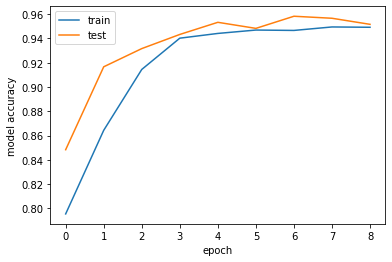

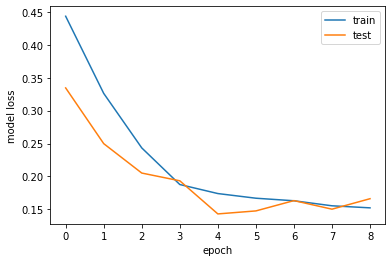

In [182]:
fit_and_plot(compile_model(activation='relu',dropout_rate=0,optimizer=opt1, x_f = 4), new_x_train, new_y_train, x_test, y_test, epochs = 9, batch_size = 20)

After all the different optimization procedures that we performed on the data, we derived the following best results:
* **Test Loss**: 0.16
* **Test Accuracy**: 95%

# Part 4 : rescaling the data to average zero

In [185]:
x_train_0 = new_x_train - 0.5 # per traslare i samples a media 1/2 a samples aventi media zero
y_train_0 = new_y_train
x_test_0 = x_test - 0.5
y_test_0 = y_test

Epoch 1/9
1920/1920 [==============================] - 19s 8ms/step - loss: 0.4863 - accuracy: 0.7750 - val_loss: 0.3554 - val_accuracy: 0.8300
Epoch 2/9
1920/1920 [==============================] - 15s 8ms/step - loss: 0.3351 - accuracy: 0.8555 - val_loss: 0.2775 - val_accuracy: 0.8967
Epoch 3/9
1920/1920 [==============================] - 13s 7ms/step - loss: 0.2484 - accuracy: 0.9124 - val_loss: 0.1872 - val_accuracy: 0.9383
Epoch 4/9
1920/1920 [==============================] - 15s 8ms/step - loss: 0.1843 - accuracy: 0.9403 - val_loss: 0.1525 - val_accuracy: 0.9533
Epoch 5/9
1920/1920 [==============================] - 14s 7ms/step - loss: 0.1719 - accuracy: 0.9447 - val_loss: 0.1441 - val_accuracy: 0.9517
Epoch 6/9
1920/1920 [==============================] - 13s 7ms/step - loss: 0.1658 - accuracy: 0.9447 - val_loss: 0.1324 - val_accuracy: 0.9567
Epoch 7/9
1920/1920 [==============================] - 13s 7ms/step - loss: 0.1582 - accuracy: 0.9478 - val_loss: 0.1543 - val_accuracy:

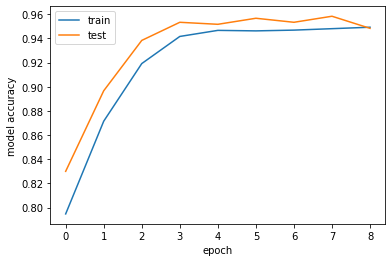

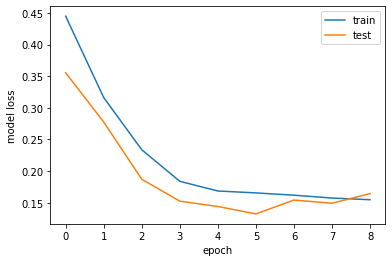

In [186]:
fit_and_plot(compile_model(activation='relu',dropout_rate=0,optimizer=opt1, x_f = 4), x_train_0, y_train_0, x_test_0, y_test_0, epochs = 9, batch_size = 20)

Pretty much nothing changed. We think that the original data [0,1] were already the best choice we could make for the problem we are treating.

When we calculate the values of each neuron inside the first hidden layer, we are actually performing a matrix product between the matrix of the weights and the values inside the input layer, therefore the resulting values inside the first hidden layer will be the sum of the weights corresponding to non-zero input values. Since the initialization of the weights is automatically performed by Keras, they happen to be already centred in zero; our rescaling operation on the input data is therefore useless.

Keras performs the Xavier normalization that it's actually non optimal with Relu activation function, the Kaiming Initialization should be more performing in our case (see as reference: https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79). We tried and used it, deriving always the same results.

The task is not extremely difficult and the structure complexity of the DNN is not extremely high, therefore we think that the problem of vanishing/exploding gradients should not weight on the performances of our algorithm.

# Appendix: filtering the augmented training data

We tried to use the DNN implemented until now to find and remove the wrong classified data created during the agumentation operation in part 2.

In [7]:
best_model = compile_model(activation='relu',dropout_rate=0,optimizer=opt1, x_f = 4) #DNN

In [8]:
best_model.fit(new_x_train, new_y_train, 
               epochs=9, batch_size=20,
                shuffle=True) #Fitting the data

Epoch 1/9
1920/1920 [==============================] - 4s 1ms/step - loss: 0.4845 - accuracy: 0.7743
Epoch 2/9
1920/1920 [==============================] - 3s 1ms/step - loss: 0.3419 - accuracy: 0.8542
Epoch 3/9
1920/1920 [==============================] - 3s 1ms/step - loss: 0.2540 - accuracy: 0.9069
Epoch 4/9
1920/1920 [==============================] - 3s 1ms/step - loss: 0.1967 - accuracy: 0.9362
Epoch 5/9
1920/1920 [==============================] - 3s 2ms/step - loss: 0.1707 - accuracy: 0.9456
Epoch 6/9
1920/1920 [==============================] - 3s 2ms/step - loss: 0.1641 - accuracy: 0.9470
Epoch 7/9
1920/1920 [==============================] - 3s 1ms/step - loss: 0.1588 - accuracy: 0.9490
Epoch 8/9
1920/1920 [==============================] - 3s 2ms/step - loss: 0.1560 - accuracy: 0.9491
Epoch 9/9
1920/1920 [==============================] - 3s 1ms/step - loss: 0.1494 - accuracy: 0.9500


In [9]:
real_mask = np.abs(new_y_train - np.concatenate(best_model.predict(new_x_train))) < 0.25 #arbitrary condition
print('wrong label: ', 1-real_mask.sum()/new_y_train.shape[0])

wrong label:  0.05789062499999997


In [10]:
real_x_train = new_x_train[real_mask]
real_y_train = new_y_train[real_mask]

Epoch 1/9
1809/1809 [==============================] - 5s 3ms/step - loss: 0.4254 - accuracy: 0.8075 - val_loss: 0.3709 - val_accuracy: 0.8583
Epoch 2/9
1809/1809 [==============================] - 3s 2ms/step - loss: 0.1854 - accuracy: 0.9204 - val_loss: 0.3204 - val_accuracy: 0.9350
Epoch 3/9
1809/1809 [==============================] - 3s 2ms/step - loss: 0.0639 - accuracy: 0.9766 - val_loss: 0.6493 - val_accuracy: 0.9417
Epoch 4/9
1809/1809 [==============================] - 3s 2ms/step - loss: 0.0277 - accuracy: 0.9919 - val_loss: 0.6854 - val_accuracy: 0.9450
Epoch 5/9
1809/1809 [==============================] - 3s 2ms/step - loss: 0.0172 - accuracy: 0.9954 - val_loss: 0.6199 - val_accuracy: 0.9533
Epoch 6/9
1809/1809 [==============================] - 3s 2ms/step - loss: 0.0126 - accuracy: 0.9962 - val_loss: 0.4909 - val_accuracy: 0.9583
Epoch 7/9
1809/1809 [==============================] - 5s 3ms/step - loss: 0.0094 - accuracy: 0.9976 - val_loss: 0.5592 - val_accuracy: 0.9550

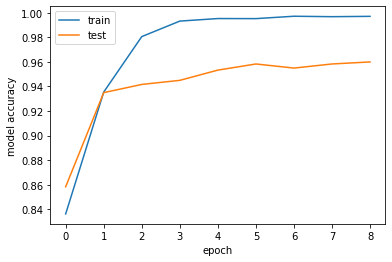

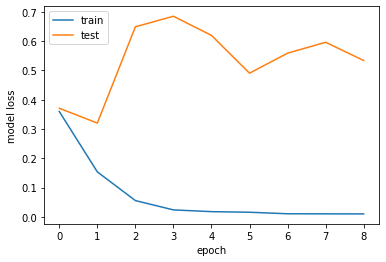

In [11]:
fit_and_plot(compile_model(activation='relu',dropout_rate=0,optimizer=opt1, x_f = 4), real_x_train, real_y_train, x_test, y_test, epochs = 9, batch_size = 20)

Looking at the final test accuracy and the learning curve, it seems that the DNN works slightly better with the new filtered data.